### Clone the Codebase git repository

In [1]:
# !git clone https://github.com/Rohithmarktricks/ERA_codebase.git
# !ls

#### Import the required modules from the cloned repository

In [18]:
from models import custom_resnet
from main import Trainer, get_adam_optimizer, get_criterion_for_classification
from utils import LRFinderCustom, Cifar10Dataset, get_device, get_dataloader_args, load_data, model_summary

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# get the device
device = get_device()
print(device)

cuda


### Use the albumentations module to create the composed image transformations (train/test) that could be used to generate the trainloader and testloader

In [4]:
# Train and test data augmentations

train_transforms = A.Compose([
    A.PadIfNeeded(min_height=36, min_width=36, border_mode=4),
    A.RandomCrop(width=32, height=32),
    A.HorizontalFlip(p=0.5),
    A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=[0.4914, 0.4822, 0.4465], p=1),
    A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616),
            p =1.0
        ),
        ToTensorV2()
    ],
    p=1.0 )


test_transforms = A.Compose(
    [
        A.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2470, 0.2435, 0.2616),
            p =1.0
        ),
        ToTensorV2()
    ],
    p=1.0
)

c:\Users\rohit\anaconda3\envs\tf\lib\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [5]:
# Hyperparameters for data
batch_size = 512
dataloader_args = get_dataloader_args(batch_size)
print(dataloader_args)

{'shuffle': True, 'batch_size': 512, 'num_workers': 4, 'pin_memory': True}


In [6]:

trainloader = load_data(train=True, dataloader_args=dataloader_args,
                       transforms=train_transforms)

testloader = load_data(train=False, dataloader_args=dataloader_args,
                      transforms = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
len(trainloader), len(testloader)

(98, 20)

### Create the model (from custom_resnet.py module)

In [8]:
# define the model and get the summary
nn_model = custom_resnet.ResNetCIFAR10().to(device)
model_summary(nn_model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1, 128,

In [9]:
# Get the required Optimizer and Criterion for CIFAR10 Classification task.

optimizer = get_adam_optimizer(nn_model, lr=1e-4, weight_decay=1e-2)
epochs = 24
criterion = get_criterion_for_classification()

print(optimizer, criterion)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
) CrossEntropyLoss()


#### display the sample images

In [10]:
images, targets = next(iter(trainloader))

In [13]:
type(images), images.shape, images[:10].shape

(torch.Tensor, torch.Size([512, 3, 32, 32]), torch.Size([10, 3, 32, 32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


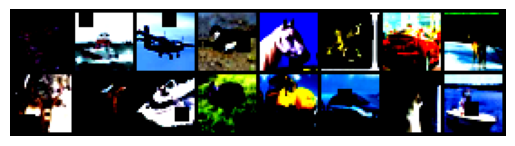

In [21]:
grid = torchvision.utils.make_grid(images[:16])
grid = grid.numpy().transpose((1,2,0))

plt.imshow(grid)
plt.axis('off')
plt.show()

### Use LR Finder to get the optimum "learning_rate" value

In [22]:
lr_finder = LRFinder(nn_model, optimizer, criterion, device='cuda' )

In [23]:
lr_finder.range_test(trainloader, end_lr=0.01, num_iter=500, step_mode='exp')

  0%|          | 0/500 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.17E-04


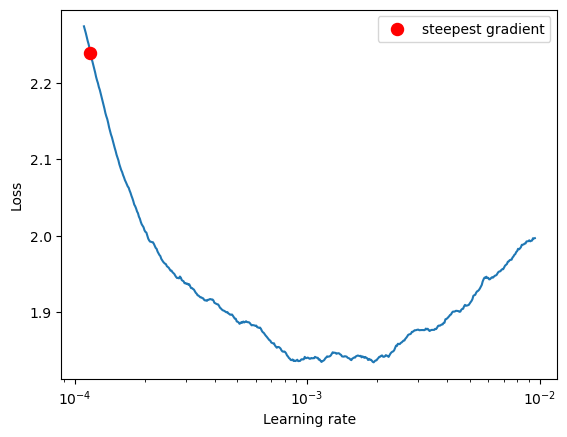

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.00011698664131013073)

In [34]:
lr_finder.plot()

In [26]:
#Reset the model params and the optimizer vals
lr_finder.reset()

### Now use the above suggested LR: 1.17E-04 as the max_lr for the OneCycleLR

In [31]:
max_lr = 1.17E-04
base_lr = max_lr/10
epochs = 24
max_momentum = 0.95
min_momentum = 0.85


In [32]:
scheduler = OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch = len(trainloader),
                      anneal_strategy='linear', div_factor = 40)

### Approach1: Source code for training and testing the model

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# Train function
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    train_losses = []
    train_accs = []
    
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Compute training accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Compute and store training loss and accuracy
        train_losses.append(loss.item())
        train_accs.append(100. * correct / total)

    # Print and store training loss and accuracy
    epoch_train_loss = sum(train_losses[-len(trainloader):]) / len(trainloader)
    epoch_train_acc = sum(train_accs[-len(trainloader):]) / len(trainloader)
    print(f"training loss: {epoch_train_loss:.4f}, accuracy: {epoch_train_acc:.2f}, Optimzer LR: {optimizer.param_groups[0]['lr']}")

    return train_losses, train_accs

# Test function
def test(model, testloader, criterion, device):
    model.eval()
    test_losses = []
    test_accs = []
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Compute test accuracy
            _, predicted = outputs.max(1)
            total = targets.size(0)
            correct = predicted.eq(targets).sum().item()

            # Compute and store test loss and accuracy
            test_losses.append(loss.item())
            test_accs.append(100. * correct / total)

        # Print and store test loss and accuracy
        test_loss = sum(test_losses) / len(testloader)
        test_acc = sum(test_accs) / len(testloader)
        print(f"Test loss: {test_loss:.4f}, accuracy: {test_acc:.2f}")

    return test_losses, test_accs


In [38]:
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train(nn_model, trainloader, optimizer, criterion, device)
    test(nn_model, testloader, criterion, device)

Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.08it/s]


training loss: 1.9938, accuracy: 46.45, Optimzer LR: 1.8791236162361622e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.90it/s]


Test loss: 1.9418, accuracy: 53.50
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.11it/s]


training loss: 1.9358, accuracy: 52.93, Optimzer LR: 3.465747232472324e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.92it/s]


Test loss: 1.8949, accuracy: 57.89
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.07it/s]


training loss: 1.8896, accuracy: 57.01, Optimzer LR: 5.052370848708487e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.84it/s]


Test loss: 1.8529, accuracy: 62.31
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.11it/s]


training loss: 1.8416, accuracy: 62.29, Optimzer LR: 6.638994464944649e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.02it/s]


Test loss: 1.8087, accuracy: 66.87
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.12it/s]


training loss: 1.8047, accuracy: 66.27, Optimzer LR: 8.22561808118081e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.96it/s]


Test loss: 1.7730, accuracy: 69.73
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.10it/s]


training loss: 1.7748, accuracy: 69.48, Optimzer LR: 9.812241697416973e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.05it/s]


Test loss: 1.7425, accuracy: 74.46
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.09it/s]


training loss: 1.7371, accuracy: 74.32, Optimzer LR: 0.00011398865313653137


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.11it/s]


Test loss: 1.7043, accuracy: 77.63
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.16it/s]


training loss: 1.7083, accuracy: 77.76, Optimzer LR: 0.00011135752139486151


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.50it/s]


Test loss: 1.7041, accuracy: 77.85
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.12it/s]


training loss: 1.6872, accuracy: 79.60, Optimzer LR: 0.00010439325309129009


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.94it/s]


Test loss: 1.7052, accuracy: 77.34
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.11it/s]


training loss: 1.6717, accuracy: 81.00, Optimzer LR: 9.742898478771866e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.88it/s]


Test loss: 1.6626, accuracy: 81.41
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.07it/s]


training loss: 1.6558, accuracy: 82.75, Optimzer LR: 9.046471648414723e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.80it/s]


Test loss: 1.6538, accuracy: 82.63
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.08it/s]


training loss: 1.6465, accuracy: 83.49, Optimzer LR: 8.35004481805758e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.91it/s]


Test loss: 1.6504, accuracy: 82.88
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.03it/s]


training loss: 1.6329, accuracy: 85.08, Optimzer LR: 7.653617987700438e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.66it/s]


Test loss: 1.6297, accuracy: 84.70
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.06it/s]


training loss: 1.6217, accuracy: 85.89, Optimzer LR: 6.957191157343294e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.49it/s]


Test loss: 1.6212, accuracy: 85.50
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.05it/s]


training loss: 1.6110, accuracy: 87.14, Optimzer LR: 6.260764326986151e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.92it/s]


Test loss: 1.6236, accuracy: 85.30
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.10it/s]


training loss: 1.6009, accuracy: 88.08, Optimzer LR: 5.5643374966290096e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.27it/s]


Test loss: 1.6071, accuracy: 86.90
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.12it/s]


training loss: 1.5899, accuracy: 89.23, Optimzer LR: 4.867910666271867e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.24it/s]


Test loss: 1.6042, accuracy: 86.97
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.18it/s]


training loss: 1.5819, accuracy: 89.53, Optimzer LR: 4.1714838359147214e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.12it/s]


Test loss: 1.5948, accuracy: 88.22
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.16it/s]


training loss: 1.5714, accuracy: 90.68, Optimzer LR: 3.47505700555758e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.03it/s]


Test loss: 1.5879, accuracy: 88.76
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.16it/s]


training loss: 1.5629, accuracy: 91.50, Optimzer LR: 2.7786301752004373e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.31it/s]


Test loss: 1.5903, accuracy: 88.52
Epoch: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.10it/s]


training loss: 1.5554, accuracy: 92.43, Optimzer LR: 2.0822033448432946e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.04it/s]


Test loss: 1.5774, accuracy: 89.54
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.16it/s]


training loss: 1.5457, accuracy: 92.95, Optimzer LR: 1.3857765144861518e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.66it/s]


Test loss: 1.5715, accuracy: 90.13
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.23it/s]


training loss: 1.5380, accuracy: 93.62, Optimzer LR: 6.8934968412900775e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.70it/s]


Test loss: 1.5673, accuracy: 90.34
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.01it/s]


training loss: 1.5319, accuracy: 94.25, Optimzer LR: -7.077146228134988e-08


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.77it/s]

Test loss: 1.5637, accuracy: 90.85


### Approach 2: Use the "Trainer" class from main.py to train and test the model

In [45]:
# nn_model = ResNetCIFAR10().to(device)
nn_trainer = Trainer(nn_model, device, criterion, optimizer, batch_size, scheduler=scheduler)


In [46]:
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    nn_trainer.train(trainloader)
    nn_trainer.test(testloader)

Epoch: 1


 Loss=2.0315043926239014 Batch_id=97 Accuracy=35.04: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


Test loss: 2.0269, accuracy: 43.59
Epoch: 2


 Loss=1.900177240371704 Batch_id=97 Accuracy=51.52: 100%|██████████████████████████████| 98/98 [00:28<00:00,  3.40it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]


Test loss: 1.9222, accuracy: 54.30
Epoch: 3


 Loss=1.7928556203842163 Batch_id=97 Accuracy=63.00: 100%|█████████████████████████████| 98/98 [00:29<00:00,  3.37it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


Test loss: 1.8118, accuracy: 65.90
Epoch: 4


 Loss=1.7588438987731934 Batch_id=97 Accuracy=70.45: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]


Test loss: 1.7639, accuracy: 70.49
Epoch: 5


 Loss=1.723996639251709 Batch_id=97 Accuracy=74.01: 100%|██████████████████████████████| 98/98 [00:29<00:00,  3.36it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


Test loss: 1.7328, accuracy: 73.68
Epoch: 6


 Loss=1.7122681140899658 Batch_id=97 Accuracy=77.08: 100%|█████████████████████████████| 98/98 [00:29<00:00,  3.28it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


Test loss: 1.6985, accuracy: 76.90
Epoch: 7


 Loss=1.698981523513794 Batch_id=97 Accuracy=78.76: 100%|██████████████████████████████| 98/98 [00:29<00:00,  3.31it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Test loss: 1.6790, accuracy: 78.83
Epoch: 8


 Loss=1.6650543212890625 Batch_id=97 Accuracy=80.49: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.44it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


Test loss: 1.6641, accuracy: 80.45
Epoch: 9


 Loss=1.6674505472183228 Batch_id=97 Accuracy=81.53: 100%|█████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


Test loss: 1.6675, accuracy: 80.41
Epoch: 10


 Loss=1.6363871097564697 Batch_id=97 Accuracy=82.51: 100%|█████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


Test loss: 1.6740, accuracy: 79.21
Epoch: 11


 Loss=1.6418497562408447 Batch_id=97 Accuracy=83.50: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.38it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]


Test loss: 1.6496, accuracy: 81.93
Epoch: 12


 Loss=1.6150057315826416 Batch_id=97 Accuracy=84.26: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Test loss: 1.6665, accuracy: 80.25
Epoch: 13


 Loss=1.642470359802246 Batch_id=97 Accuracy=84.56: 100%|██████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]


Test loss: 1.6916, accuracy: 77.39
Epoch: 14


 Loss=1.6270610094070435 Batch_id=97 Accuracy=85.26: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Test loss: 1.6689, accuracy: 79.61
Epoch: 15


 Loss=1.5990655422210693 Batch_id=97 Accuracy=85.92: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


Test loss: 1.6389, accuracy: 82.96
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]


Test loss: 1.6171, accuracy: 85.16
Epoch: 17


 Loss=1.6067029237747192 Batch_id=97 Accuracy=86.90: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


Test loss: 1.6382, accuracy: 83.01
Epoch: 18


 Loss=1.5948160886764526 Batch_id=97 Accuracy=87.23: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.46it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


Test loss: 1.6289, accuracy: 83.83
Epoch: 19


 Loss=1.600714921951294 Batch_id=97 Accuracy=87.62: 100%|██████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Test loss: 1.6129, accuracy: 85.57
Epoch: 20


 Loss=1.5700970888137817 Batch_id=97 Accuracy=88.08: 100%|█████████████████████████████| 98/98 [00:31<00:00,  3.15it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


Test loss: 1.6347, accuracy: 83.05
Epoch: 21


 Loss=1.598025918006897 Batch_id=97 Accuracy=88.23: 100%|██████████████████████████████| 98/98 [00:29<00:00,  3.36it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Test loss: 1.6122, accuracy: 85.60
Epoch: 22


 Loss=1.6038981676101685 Batch_id=97 Accuracy=88.76: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.47it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Test loss: 1.6203, accuracy: 84.80
Epoch: 23


 Loss=1.593686819076538 Batch_id=97 Accuracy=89.03: 100%|██████████████████████████████| 98/98 [00:28<00:00,  3.47it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]


Test loss: 1.6025, accuracy: 86.50
Epoch: 24


 Loss=1.5937389135360718 Batch_id=97 Accuracy=89.33: 100%|█████████████████████████████| 98/98 [00:28<00:00,  3.47it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]

Test loss: 1.5995, accuracy: 87.11
